In [ ]:
# This notebook has been run on Google Colab. To run it, uncomment the following lines

# !rm -r Few-shot-learning-with-HuBERT
# !git clone https://github.com/luckyman94/Few-shot-learning-with-HuBERT.git
# !pip install -U kagglehub

# !rm -r kagglehub_cache/


rm: cannot remove 'Few-shot-learning-with-HuBERT': No such file or directory
Cloning into 'Few-shot-learning-with-HuBERT'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269 (from 1)
Receiving objects: 100% (269/269), 4.31 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (117/117), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.13
    Uninstalling kagglehub-0.3.13:
      Successfully uninstalled kagglehub-0.3.13
rm: cannot remove 'kagglehub_cache/': No such file or directory


In [ ]:

import os
import sys
from pathlib import Path
import torch

# ---- Hugging Face token ----
# Uncomment the following line if you want to run the notebook on Google Colab. Make sure to replace "YOUR
#os.environ["HF_TOKEN"] = "YOUR TOKEN HERE"

# Uncomment the following lines if you want to run the notebook on Google Colab
#ROOT = Path.cwd() / "Few-shot-learning-with-HuBERT"
#sys.path.append(str(ROOT))

assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))



from transformers import HubertModel

from src.datasets.crema import CremaDDataset
from src.methods.fewshot.benchmark import benchmark_fewshot
from src.evaluation.evaluate import evaluate_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
dataset = CremaDDataset()

print("Classes :", dataset.classes)
print("Nombre total de fichiers :", len(dataset))

x, y = dataset[0]
print(x.shape, y)


Using Colab cache for faster access to the 'cremad' dataset.
Classes : ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad']
Nombre total de fichiers : 7442
torch.Size([24000]) 1


In [4]:
from tqdm import tqdm
import torch

X = []
y = []

for waveform, label in tqdm(dataset, desc="Loading dataset"):
    X.append(waveform)
    y.append(label)

X = torch.stack(X)
y = torch.tensor(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


Loading dataset: 100%|██████████| 7442/7442 [02:26<00:00, 50.82it/s]


X shape: torch.Size([7442, 24000])
y shape: torch.Size([7442])


In [5]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

In [6]:
results = {}
for k in [1,5,10]:
    results[k] = benchmark_fewshot(model=hubert, X=X, y=y, device=device, k_shot=k, n_tasks=100)


10-shot benchmark: 100%|██████████| 100/100 [03:00<00:00,  1.81s/it]



===== Few-shot evaluation summary =====

--- 1-shot ---
Accuracy : 0.2666 ± 0.0626
F1 macro : 0.2649


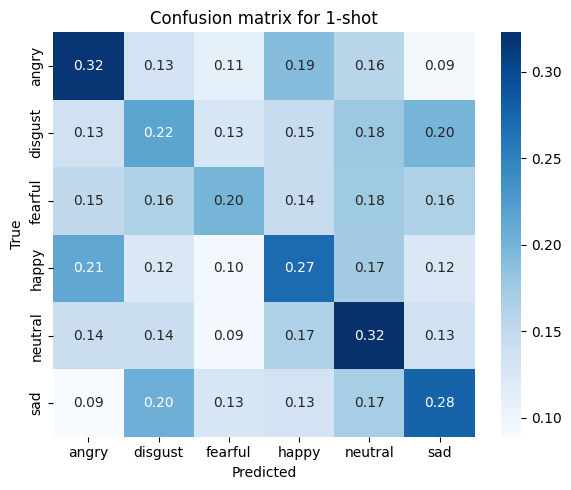


=== Evaluation metrics ===
accuracy    : 0.2666
f1_macro    : 0.2649
precision_macro: 0.2659
recall_macro: 0.2668


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


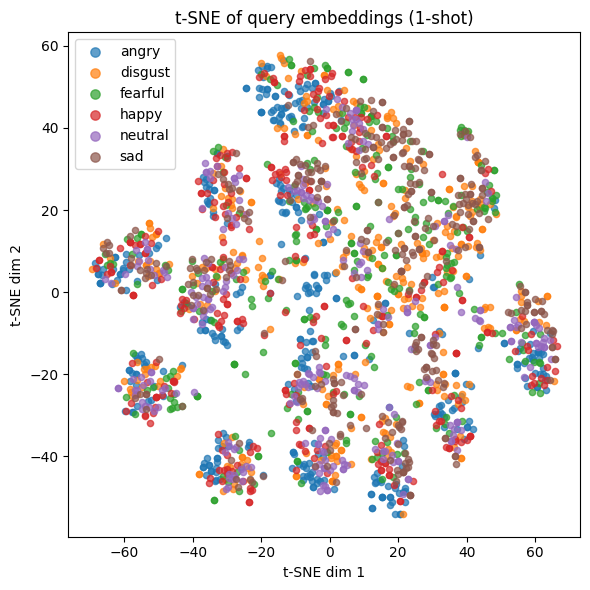


--- 5-shot ---
Accuracy : 0.3310 ± 0.0612
F1 macro : 0.3286


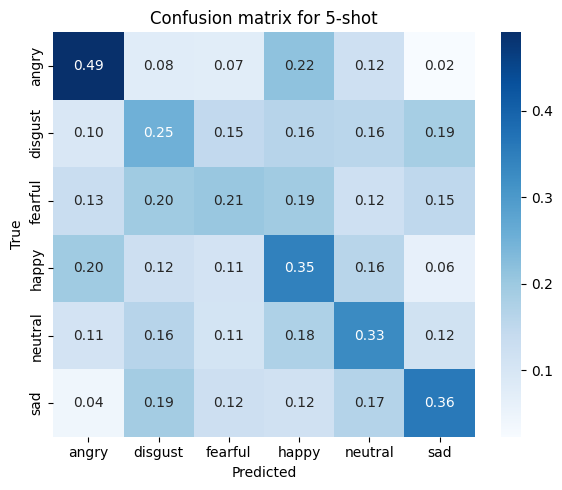


=== Evaluation metrics ===
accuracy    : 0.3310
f1_macro    : 0.3286
precision_macro: 0.3292
recall_macro: 0.3304


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


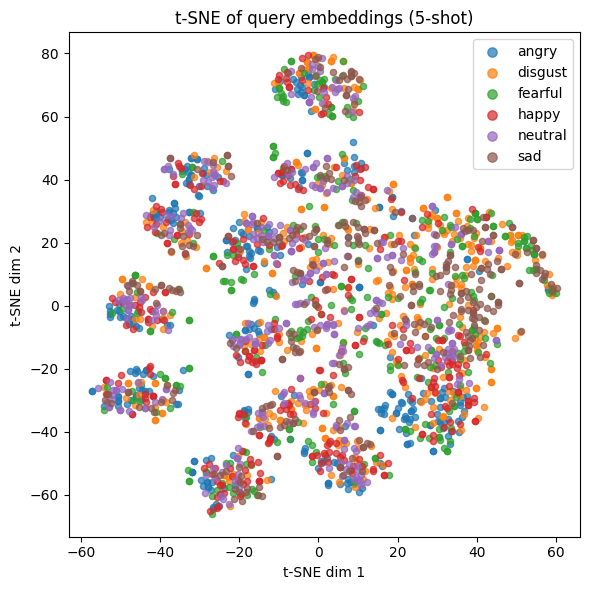


--- 10-shot ---
Accuracy : 0.3683 ± 0.0551
F1 macro : 0.3605


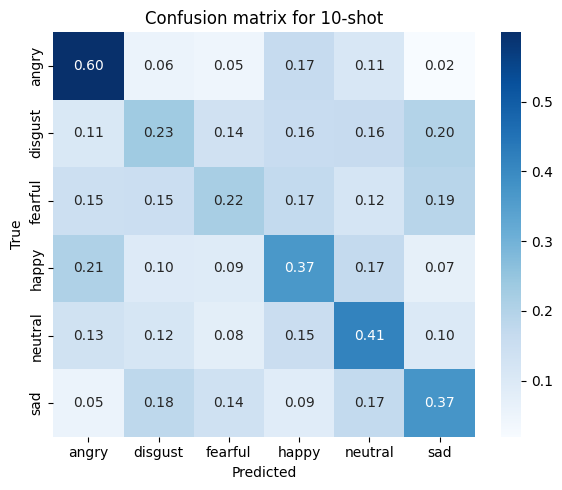


=== Evaluation metrics ===
accuracy    : 0.3683
f1_macro    : 0.3605
precision_macro: 0.3593
recall_macro: 0.3680


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


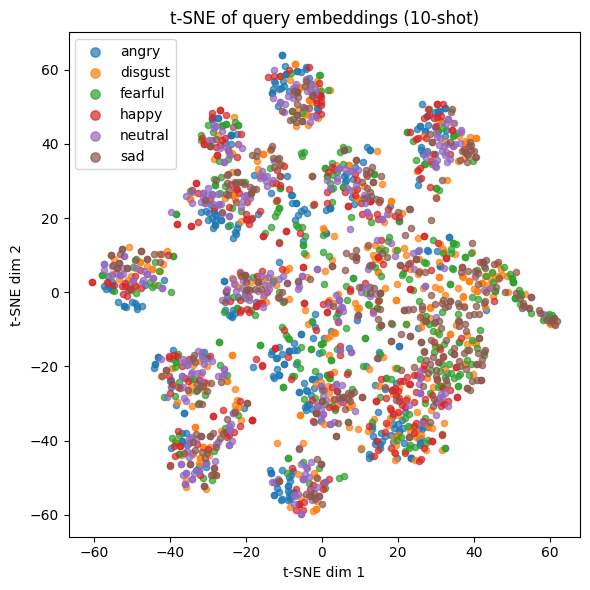

In [7]:
evaluate_benchmark(results, class_names=dataset.classes)